# General Techniques

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, roc_curve, auc
from scipy.stats import ks_2samp
from sklearn.utils import shuffle
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import Datasets
import Plotting
import Tools

In [2]:
matplotlib.rcParams['figure.figsize'] = (10, 5)

In [3]:
sig_train = Datasets.gen_spiral( a=0.2, s=0.0, n=1000, w=0.15 )
sig_test  = Datasets.gen_spiral( a=0.2, s=0.0, n=1000, w=0.15 )

bkg_train = Datasets.gen_spiral( a=-0.2, s=0.2, n=1000, w=0.15 )
bkg_test  = Datasets.gen_spiral( a=-0.2, s=0.2, n=1000, w=0.15 )

ABDT = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=3),
                         algorithm="SAMME",
                         n_estimators=100)

Tools.train_mva(ABDT,sig_train,bkg_train)

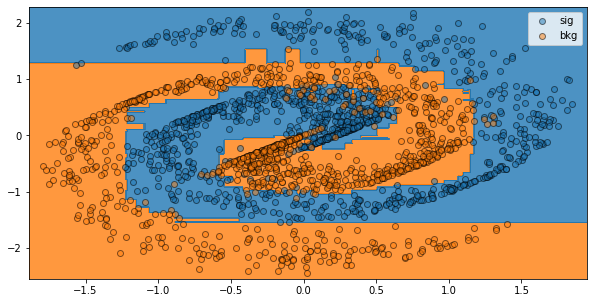

In [4]:
Tools.evaluate_mva(ABDT,sig_train,bkg_train)
plt.show()

In [5]:
def plot_output(clf,sig,bkg):

    n_bins = 40
    
    sig_output = clf.decision_function(sig.values)
    bkg_output = clf.decision_function(bkg.values)
    
    d_min = min(sig_output.min(),bkg_output.min())
    d_max = max(sig_output.max(),bkg_output.max())
    
    plt.hist(bkg_output,bins=n_bins,range=(d_min,d_max), color='tab:orange', label='bkg train',alpha=0.6, density=True)
    plt.hist(sig_output,bins=n_bins,range=(d_min,d_max), color='tab:blue', label='sig train', alpha=0.6, density=True)

    plt.legend()
    plt.show()

    return

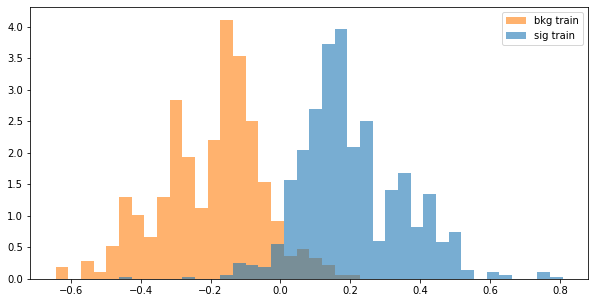

In [6]:
plot_output(ABDT,sig_test,bkg_test)

In [7]:
def calc_roc(clf,sig,bkg):
    X = np.concatenate( [sig.values,bkg.values] )
    y = np.concatenate( [np.ones(len(sig.index)),np.zeros(len(bkg.index))] )

    y_score = clf.decision_function(X)

    fpr, tpr, _ = roc_curve(y.ravel(), y_score.ravel())

    roc_auc = auc(fpr,tpr)

    plt.figure()
    plt.plot(tpr,1-fpr,color='tab:orange', lw=2, label='ROC Curve (area = %0.2f)'%roc_auc)
    #plt.plot([1,0],[1,0], color='tab:blue', lw=2, linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('Sig Eff')
    plt.ylabel('1 - Bkg Eff')
    plt.legend(loc='best')
    
    plt.show()
    
    return roc_auc

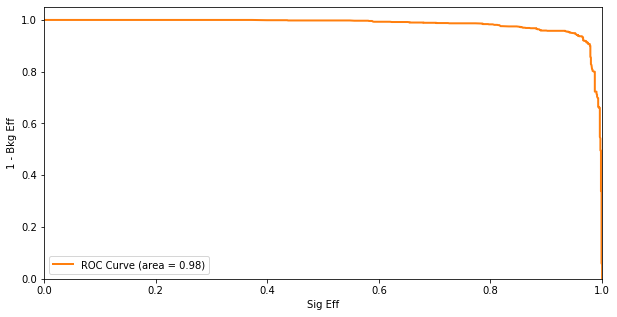

Test AUC:  0.9834480000000001


In [8]:
test_auc = calc_roc(ABDT,sig_test,bkg_test)
print("Test AUC: ",test_auc)

In [9]:
def plot_compare_outputs(clf,sig_train,bkg_train,sig_test,bkg_test):

    n_bins = 40
    
    sig_train_output = clf.decision_function(sig_train.values)
    bkg_train_output = clf.decision_function(bkg_train.values)

    sig_test_output = clf.decision_function(sig_test.values)
    bkg_test_output = clf.decision_function(bkg_test.values)
    
    d_min = min(sig_train_output.min(),bkg_train_output.min())
    d_max = max(sig_train_output.max(),bkg_train_output.max())
    
    sig_tr,bins,_ = plt.hist(bkg_train_output,bins=n_bins,range=(d_min,d_max), color='tab:orange', label='bkg train',alpha=0.6, density=True)
    plt.hist(sig_train_output,bins=n_bins,range=(d_min,d_max), color='tab:blue', label='sig train', alpha=0.6, density=True)

    bin_centers = (bins[:-1]+bins[1:])/2
    sig_te,_ = np.histogram(sig_test_output,bins=bins,density=True)
    bkg_te,_ = np.histogram(bkg_test_output,bins=bins,density=True)

    plt.plot(bin_centers,bkg_te, 'o', c='tab:orange', label='bkg test', alpha=0.9, markeredgecolor='k')
    plt.plot(bin_centers,sig_te, 'o', c='tab:blue', label='sig test', alpha=0.9, markeredgecolor='k')

    print(ks_2samp(sig_tr,sig_te))
    
    plt.legend()
    plt.show()

    return

Ks_2sampResult(statistic=0.15000000000000002, pvalue=0.7236654245436781)


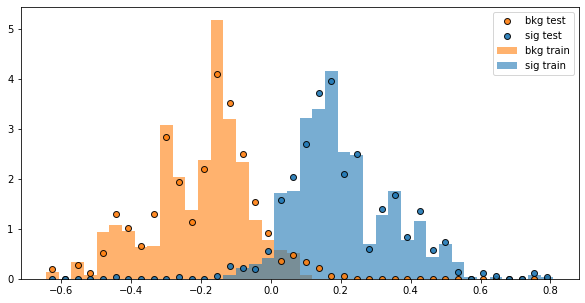

In [10]:
plot_compare_outputs(ABDT,sig_train,bkg_train,sig_test,bkg_test)

In [11]:
def errorVsSize(clf,cv,sig,bkg,njobs,train_sizes=np.linspace(.1, 1.0, 10)):
    
    X = np.concatenate( [sig.values,bkg.values] )
    y = np.concatenate( [np.ones(len(sig.index)),np.zeros(len(bkg.index))] )

    X,y = shuffle(X,y)

    train_sizes, train_scores, test_scores = learning_curve(clf, X, y, cv=cv, n_jobs=njobs, train_sizes=train_sizes)
    
    train_errors_mean = np.mean(train_scores, axis=1)
    train_errors_std = np.std(train_scores, axis=1)
    test_errors_mean = np.mean(test_scores, axis=1)
    test_errors_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.xlabel("Training Samples")
    plt.ylabel("1-Error")

    plt.grid()
    plt.fill_between(train_sizes, train_errors_mean - train_errors_std,
                     train_errors_mean + train_errors_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_errors_mean - test_errors_std,
                     test_errors_mean + test_errors_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_errors_mean, 'o-', color="r",
             label="Training Error")
    plt.plot(train_sizes, test_errors_mean, 'o-', color="g",
             label="Test Error")

    plt.legend(loc="best")
    plt.show()
    
    return

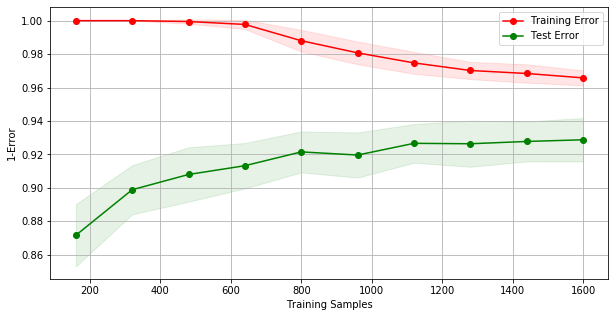

In [12]:
sig = Datasets.gen_spiral( a=0.2, s=0.0, n=1000, w=0.15 )
bkg = Datasets.gen_spiral( a=-0.2, s=0.2, n=1000, w=0.15 )

ABDT = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=3),
                         algorithm="SAMME",
                         n_estimators=100)

cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
errorVsSize(ABDT,cv,sig,bkg,4)